In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [3]:
#height and width refer to the size of the image
#channels refers to the amoitn of color channels
image_dimensions={'height':256,'width':256,'channels':3}

In [4]:
#creat a classifier class

class Classifier:
    def __init__():
        self.model=0
    def predict(self,x):
        return self.model.predict(x)
    def fit(self,x,y):
        return self.model.train_on_batch(x,y)
    
    def get_accuracy(self,x,y):
        return self.model.test_on_batch(x,y)
    
    def load(self,path):
        self.model.load_weights(path)

        

In [5]:
#create a MesoNet class using the classifier

class Meso4(Classifier):
    def __init__(self,learning_rate=0.001):
        self.model=self.init_model()
        optimizer=Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer,
                          loss='mean_squared_error',
                          metrics=['accuracy'])
    #create our architecture
    def init_model(self):
        x=Input(shape=(image_dimensions['height'],image_dimensions['width'],
                      image_dimensions['channels']))
        x1=Conv2D(8,(3,3),padding='same',activation='relu')(x)
        x1=BatchNormalization()(x1)
        x1=MaxPooling2D(pool_size=(2,2),padding='same')(x1)
        
        x2=Conv2D(8,(5,5),padding='same',activation='relu')(x1)
        x2=BatchNormalization()(x2)
        x2=MaxPooling2D(pool_size=(2,2),padding='same')(x2)
        
        x3=Conv2D(16,(5,5),padding='same',activation='relu')(x2)
        x3=BatchNormalization()(x3)
        x3=MaxPooling2D(pool_size=(2,2),padding='same')(x3)
        
        x4=Conv2D(16,(5,5),padding='same',activation='relu')(x3)
        x4=BatchNormalization()(x4)
        x4=MaxPooling2D(pool_size=(4,4),padding='same')(x4)
        
        #batch normalization is to perform speed
        #normalize the inputs to each layer of the network
        #pooling layer: reduce dimensions to decrease speed of computation: max pooling is by taking the max value of the region of pixels
        
        y=Flatten()(x4)
        y=Dropout(0.5)(y)
        y=Dense(16)(y)
        y=LeakyReLU(alpha=0.1)(y)
        y=Dropout(0.5)(y)
        y=Dense(1,activation='sigmoid')(y)
        return Model(inputs=x,outputs=y)
        
        

In [6]:
#instantiate the mesonet model with pretrained weights
meso=Meso4()
meso.load('./weights/Meso4_DF')

In [7]:
#prepare the dataset
#rescaling pixel values between 1 and 255 to a range between 0 and 1
dataGenerator=ImageDataGenerator(rescale=1./255)

#instantiating generator to feed images through the network 
generator=dataGenerator.flow_from_directory('./data/',
                                           target_size=(256,256),
                                           batch_size=1,
                                           class_mode='binary')

Found 7104 images belonging to 2 classes.


In [8]:
#cheking class assignment
generator.class_indices

{'DeepFake': 0, 'Real': 1}

1/1 [==============================] - 0s 337ms/step
Predicted likelihood:0.8936
Actual label:1
1/1 [==============================] - 0s 22ms/step

Correct prediction:True


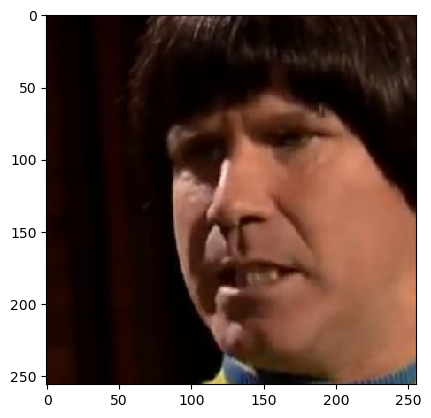

In [9]:
#Rendering image X with label y for MesoNet
X,y=generator.next()
#Evaluating prediction
print(f"Predicted likelihood:{meso.predict(X)[0][0]:.4f}")
print(f"Actual label:{int(y[0])}")
print(f"\nCorrect prediction:{round(meso.predict(X)[0][0])==y[0]}")

#showing image
#our data has currentlu an extra dimension for its position in the batch and this needs to be removed before imshow so that it can properly render the image
#this is why we use the numpy function squeeze
plt.imshow(np.squeeze(X))


In [10]:
#creating separate lists for correctly classified and misclassified images
correct_real=[]
correct_real_pred=[]

correct_deepfake=[]
correct_deepfake_pred=[]

misclassified_real=[]
misclassified_real_pred=[]

misclassified_deepfake=[]
misclassified_deepfake_pred=[]

In [11]:
# Generating predictions on validation set, storing in separate lists
for i in range(len(generator.labels)):
    
    # Loading next picture, generating prediction
    X, y = generator.next()
    pred = meso.predict(X)[0][0]
    
    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)   
        
    # Printing status update
    if i % 1000 == 0:
        print(i, ' predictions completed.')
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")

1/1 [==============================] - 0s 23ms/step
0  predictions completed.
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


KeyboardInterrupt: 

In [ ]:
def plotter(images,preds):
    fig=plt.figure(figsize=(16,9))
    subset=np.random.randint(0,len(images)-1,12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax=plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show
    return
        

In [ ]:
plotter(correct_real,correct_real_pred)

In [ ]:
plotter(misclassified_real,misclassified_real_pred)

In [ ]:
#correctly identified deepfakes
plotter(correct_deepfake,correct_deepfake_pred)

In [ ]:
plotter(misclassified_deepfake,misclassified_deepfake_pred)

In [ ]:
#let's show an image which is fake
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the path to your image file
image_path = "deepfake_1.jpg"

# Load the image
image = mpimg.imread(image_path)

# Plot the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
#let's use mesonet to predict on this image
image.shape

In [ ]:
from PIL import Image
image = Image.open("deepfake_1.jpg")
image = image.resize((256, 256))
resized_image_path = "C:\\Users\\WhiteLuce SIS\\OneDrive\\PFE tests\\deepfakes_detection\\weights\\deepfake_1.jpg"
image.save(resized_image_path)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the path to your image file
image_path = "C:\\Users\\WhiteLuce SIS\\OneDrive\\PFE tests\\deepfakes_detection\\weights\\deepfake_1.jpg"

# Load the image
image = mpimg.imread(image_path)

# Plot the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
image.shape

In [ ]:
pred = meso.predict(image)[0][0]

In [ ]:
from PIL import Image
import numpy as np
# Specify the path to your image file
image_path = "C:\\Users\\WhiteLuce SIS\\OneDrive\\PFE tests\\deepfakes_detection\\weights\\deepfakes\\deepfake_2.jpg"

# Open the image
image = Image.open(image_path)

# Resize the image to the desired dimensions
image = image.resize((256, 256))

# Convert the image to a NumPy array
image_array = np.array(image)

# Reshape the image array to include the batch dimension
image_array = image_array.reshape((1, 256, 256, 3))
resized_image_path = "C:\\Users\\WhiteLuce SIS\\OneDrive\\PFE tests\\deepfakes_detection\\weights\\deepfakes\\deepfake_3.jpg"
image.save(resized_image_path)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the path to your image file
image_path = "C:\\Users\\WhiteLuce SIS\\OneDrive\\PFE tests\\deepfakes_detection\\weights\\deepfakes\\deepfake_3.jpg"

# Load the image
image = mpimg.imread(image_path)

# Plot the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
image.shape

In [ ]:
dataGenerator=ImageDataGenerator(rescale=1./255)

#instantiating generator to feed images through the network 
generator=dataGenerator.flow_from_directory("C:\\Users\\WhiteLuce SIS\\OneDrive\\PFE tests\\deepfakes_detection\\weights",
                                           target_size=(256,256),
                                           batch_size=1,
                                           class_mode='binary')

In [ ]:
generator.class_indices

In [ ]:
im,y=generator.next()
print(f"Predicted likelihood:{meso.predict(im)[0][0]:.4f}")

In [ ]:
print(f"Predicted likelihood:{meso.predict(im)[0][0]:.4f}")
print(f"Actual label:{int(y[0])}")
print(f"\nCorrect prediction:{round(meso.predict(im)[0][0])==y[0]}")

#showing image
#our data has currentlu an extra dimension for its position in the batch and this needs to be removed before imshow so that it can properly render the image
#this is why we use the numpy function squeeze
plt.imshow(np.squeeze(im))

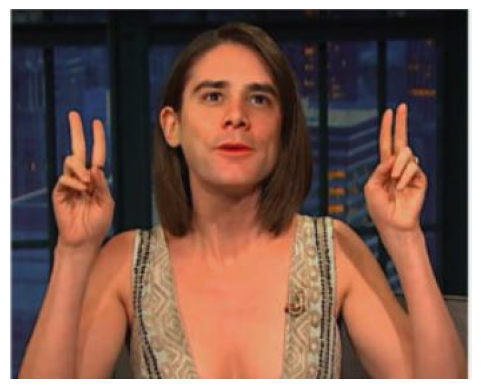

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the path to your image file
image_path = "C:\\Users\\WhiteLuce SIS\\OneDrive\\PFE tests\\deepfakes_detection\\deepfake_1.jpg"

# Load the image
image = mpimg.imread(image_path)

# Plot the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [16]:
dataGenerator=ImageDataGenerator(rescale=1./255)

#instantiating generator to feed images through the network 
generator=dataGenerator.flow_from_directory("C:\\Users\\WhiteLuce SIS\\OneDrive\\PFE tests\\deepfakes_detection\\weights",
                                           target_size=(256,256),
                                           batch_size=1,
                                           class_mode='binary')

Found 1 images belonging to 1 classes.


In [17]:
generator.class_indices

{'deepfakes': 0}

In [19]:
im,y=generator.next()
print(f"Predicted likelihood:{meso.predict(im)[0][0]:.4f}")

1/1 [==============================] - 0s 21ms/step
Predicted likelihood:0.9257


In [20]:
dataGenerator=ImageDataGenerator(rescale=1./255)

#instantiating generator to feed images through the network 
generator=dataGenerator.flow_from_directory("C:\\Users\\WhiteLuce SIS\\OneDrive\\PFE tests\\deepfakes_detection\\weights",
                                           target_size=(256,256),
                                           batch_size=1,
                                           class_mode='binary')

Found 1 images belonging to 1 classes.


In [21]:
im,y=generator.next()
print(f"Predicted likelihood:{meso.predict(im)[0][0]:.4f}")

1/1 [==============================] - 0s 24ms/step
Predicted likelihood:0.8783
